# Offside

## Introduction, Reference Domain, and Objectives
The offside project starts from the need of creating a recommendation system based on machine learning which, given a football player, returns a series of players as similar as possible based on a set of technical-tactical data. The reference domain is, obviously, the world of football, and the reference platform for data retrieval is Fbref, a consultation source that includes data relating to players, teams and championships in an easily to consult, -and scrape-, fashion.

The approach that the project intends to adopt is based on a rather simple notion: let's assume we have a two-dimensional Cartesian plane, where each point corresponds to a player based on a pair of technical characteristics of our choice. The players most similar to the original player will be those who have the smallest distance on the Cartesian plane. It is sufficient to raise the plane to n dimensions, one for each of the technical attributes considered, to evaluate the similarity of the players on the hyperplane. The only caveat is that calculating the distance on a n-dimensional plane requires a little bit more effort than doing the same thing for a bi-dimensional plane, but thanks to the use of the Euclidean distance, the problem will be solved quite easily. In the code block that follows, we will begin by importing all the necessary libraries for the model.

In [239]:
# Import necessary libraries
import requests
import pandas as pd
from scipy.spatial.distance import euclidean

## Description of the Data Retrieval Phase
This section aims to retrieve data from a Web URL. The specified URL points to a webpage on FBref, a website that, as we mentioned earlier, provides comprehensive football statistics and tables. In particular, the URL variable holds the address of the webpage containing Serie A statistics. The `pd.read_html()` function in the code down below is utilized to parse the HTML content of the webpage and extract tables. However, prior to parsing, the `.replace()` method is employed to remove HTML comment tags ('<!--' and '-->') from the webpage content. This is done to ensure that the HTML can be imported correctly and without hidden elements ruining the formatting, so that it may then be parsed by `read_html()`. This workaround used was found with a quick search on StackOverflow (https://stackoverflow.com/questions/77548912/how-to-extract-table-from-a-webpage-using-its-id)

We then have the `pd.read_html()` function call, inside of which the `requests.get(url).text` retrieves the HTML content of the specified URL, which is then passed to `read_html()` for parsing. The `attrs` parameter is utilized to specify the HTML attribute `id` of the table element that we actually need to be extracted, which in this case is 'stats_standard', a table containing attributes for the players in Serie A. The `[0]` index is appended to the end of the function call to select the first table found on the webpage matching the specified attributes.

In [240]:
# Define the URL for data extraction
url = 'https://fbref.com/en/comps/11/stats/Serie-A-Stats'

# Utilize the pandas library to read HTML content from the specified URL
# Replace HTML comments to ensure correct parsing of the content
# Extract the data table with the specified attributes
df = pd.read_html(
    requests.get(url).text.replace('<!--','').replace('-->','')
    ,attrs={'id':'stats_standard'}
)[0]

## Description of the Data Preparation Phase

After scraping the data, we need to prepare it for further analysis and processing. First of all, the column names are re-defined to enhance clarity and comprehension of the dataset. These new column names are structured hierarchically in order to categorize various aspects of player information, performance metrics, and expected outcomes. After the renaming process, the data types of some specific columns are adjusted to ensure consistency and suitability for analysis. Columns containing strings are converted to the string data type, while categorical columns are converted to categorical data type for efficient storage and computation. Additionally, columns representing numerical data are converted to numeric type, with appropriate error handling to manage any inconsistencies or invalid entries. As the model will be based on the computation of the n-Dimensional Euclidean Distance (where n is the amount of attributes considered), we will need several numerical values in order to make a model that is precise and consistent.

Furthermore, unnecessary information is removed from the dataset to streamline its structure and optimize the analytical processes. Columns such as alphabetical rank and nationality are deemed irrelevant for the intended analysis, as they do not contribute significantly to player comparisons or performance evaluations. In the same way, redundancies are removed: we already have the year of birth of a player, so the age attribute is irrelevant and essentially duplicate information. Additionally, a redundant hyperlink column (in particular, the last column, provided by Fbref as a Hyperlink to another page) is eliminated. Finally, the processed dataset is exported to a CSV file named "serieA.csv" to facilitate future analysis and sharing. What follows is a description of the columns of the dataset as provided by the website.

### Dataset Columns Explanation

#### Background Information
1. **(Background Information, Alphabetical Rank)**: represents the alphabetical ranking of the players *[REDACTED]*
2. **(Background Information, Full Name)**: indicates the full name of the player
3. **(Background Information, Nation)**: specifies the nationality of the player *[REDACTED]*
4. **(Background Information, Position)**: specifies the primary position of the player
5. **(Background Information, Squad)**: denotes the squad the player belongs to
6. **(Background Information, Age)**: represents the age of the player *[REDACTED]*
7. **(Background Information, Year of Birth)**: indicates the year of birth of the player

#### Playing Time
8. **(Playing Time, MP)**: stands for Matches Played.
9. **(Playing Time, Starts)**: denotes the number of matches started by the player
10. **(Playing Time, Min)**: represents the total minutes played by the player
11. **(Playing Time, 90s)**: indicates the total minutes played divided by 90

#### Performance
12. **(Performance, Gls)**: represents the number of goals scored by the player
13. **(Performance, Ast)**: denotes the number of assists made by the player
14. **(Performance, G+A)**: indicates the total number of goals and assists combined
15. **(Performance, G-PK)**: represents the number of goals scored excluding penalty kicks
16. **(Performance, PK)**: denotes the number of penalty kicks scored by the player
17. **(Performance, PKatt)**: represents the number of penalty kicks attempted by the player
18. **(Performance, CrdY)**: indicates the number of yellow cards received by the player
19. **(Performance, CrdR)**: denotes the number of red cards received by the player

#### Expected
20. **(Expected, xG)**: represents the expected goals for the player
21. **(Expected, npxG)**: denotes the non-penalty expected goals for the player
22. **(Expected, xAG)**: represents the expected assists for the player
23. **(Expected, npxG+xAG)**: indicates the sum of non-penalty expected goals and expected assists

#### Progression
24. **(Progression, PrgC)**: stands for progressive carries made by the player
25. **(Progression, PrgP)**: denotes progressive passes made by the player
26. **(Progression, PrgR)**: represents progressive carries made by the player

#### Per 90 Minutes
27. **(Per 90 Minutes, Gls)**: represents the average number of goals scored per 90 minutes
28. **(Per 90 Minutes, Ast)**: denotes the average number of assists made per 90 minutes
29. **(Per 90 Minutes, G+A)**: indicates the average number of goals and assists combined per 90 minutes
30. **(Per 90 Minutes, G-PK)**: represents the average number of goals scored excluding penalty kicks per 90 minutes
31. **(Per 90 Minutes, G+A-PK)**: denotes the average number of goals and assists combined excluding penalty kicks per 90 minutes
32. **(Per 90 Minutes, xG)**: represents the average expected goals per 90 minutes
33. **(Per 90 Minutes, xAG)**: denotes the average expected assists per 90 minutes
34. **(Per 90 Minutes, xG+xAG)**: indicates the average sum of expected goals and expected assists per 90 minutes
35. **(Per 90 Minutes, npxG)**: represents the average non-penalty expected goals per 90 minutes
36. **(Per 90 Minutes, npxG+xAG)**: denotes the average sum of non-penalty expected goals and expected assists per 90 minutes
37. **(Hyperlink Column)**: shows a hyperlink to another page of the website *[REDACTED]*

These columns collectively provide a comprehensive overview of player performance, background, and progression metrics, facilitating in-depth analysis and insights as the further progression of the model will demonstrate.


In [241]:
# Comments on Data Processing Pipeline

# Define the new column names to be used for the DataFrame
new_columns = [
    "(Background Information, Alphabetical Rank)",
    "(Background Information, Full Name)",
    "(Background Information, Nation)",
    "(Background Information, Position)",
    "(Background Information, Squad)",
    "(Background Information, Age)",
    "(Background Information, Year of Birth)",
    "(Playing Time, MP)",
    "(Playing Time, Starts)",
    "(Playing Time, Min)",
    "(Playing Time, 90s)",
    "(Performance, Gls)",
    "(Performance, Ast)",
    "(Performance, G+A)",
    "(Performance, G-PK)",
    "(Performance, PK)",
    "(Performance, PKatt)",
    "(Performance, CrdY)",
    "(Performance, CrdR)",
    "(Expected, xG)",
    "(Expected, npxG)",
    "(Expected, xAG)",
    "(Expected, npxG+xAG)",
    "(Progression, PrgC)",
    "(Progression, PrgP)",
    "(Progression, PrgR)",
    "(Per 90 Minutes, Gls)",
    "(Per 90 Minutes, Ast)",
    "(Per 90 Minutes, G+A)",
    "(Per 90 Minutes, G-PK)",
    "(Per 90 Minutes, G+A-PK)",
    "(Per 90 Minutes, xG)",
    "(Per 90 Minutes, xAG)",
    "(Per 90 Minutes, xG+xAG)",
    "(Per 90 Minutes, npxG)",
    "(Per 90 Minutes, npxG+xAG)"
] + list(df.columns[36:])  

# Assign the new column names to the DataFrame
df.columns = new_columns

# Convert specific columns to appropriate data types
df["(Background Information, Full Name)"] = df["(Background Information, Full Name)"].astype("string")
df["(Background Information, Position)"] = df["(Background Information, Position)"].astype("category")
df["(Background Information, Squad)"] = df["(Background Information, Squad)"].astype("category")

# List of numerical columns to be converted to numeric type
numerical_columns_to_convert = [
    "(Background Information, Year of Birth)",
    "(Playing Time, MP)",
    "(Playing Time, Starts)",
    "(Playing Time, Min)",
    "(Playing Time, 90s)",
    "(Performance, Gls)",
    "(Performance, Ast)",
    "(Performance, G+A)",
    "(Performance, G-PK)",
    "(Performance, PK)",
    "(Performance, PKatt)",
    "(Performance, CrdY)",
    "(Performance, CrdR)",
    "(Expected, xG)",
    "(Expected, npxG)",
    "(Expected, xAG)",
    "(Expected, npxG+xAG)",
    "(Progression, PrgC)",
    "(Progression, PrgP)",
    "(Progression, PrgR)",
    "(Per 90 Minutes, Gls)",
    "(Per 90 Minutes, Ast)",
    "(Per 90 Minutes, G+A)",
    "(Per 90 Minutes, G-PK)",
    "(Per 90 Minutes, G+A-PK)",
    "(Per 90 Minutes, xG)",
    "(Per 90 Minutes, xAG)",
    "(Per 90 Minutes, xG+xAG)",
    "(Per 90 Minutes, npxG)",
    "(Per 90 Minutes, npxG+xAG)"
]

# Convert specified columns to numeric data type
for col in numerical_columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop unnecessary columns from the DataFrame
df.drop('(Background Information, Alphabetical Rank)', axis=1, inplace=True)
df.drop('(Background Information, Nation)', axis=1, inplace=True)
df.drop('(Background Information, Age)', axis=1, inplace=True)
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

# Export the processed DataFrame to a CSV file
df.to_csv("serieA.csv", encoding='utf-8', index=False)

# Return the modified DataFrame
df

,"(Background Information, Full Name)","(Background Information, Position)","(Background Information, Squad)","(Background Information, Year of Birth)","(Playing Time, MP)","(Playing Time, Starts)","(Playing Time, Min)","(Playing Time, 90s)","(Performance, Gls)","(Performance, Ast)",...,"(Per 90 Minutes, Gls)","(Per 90 Minutes, Ast)","(Per 90 Minutes, G+A)","(Per 90 Minutes, G-PK)","(Per 90 Minutes, G+A-PK)","(Per 90 Minutes, xG)","(Per 90 Minutes, xAG)","(Per 90 Minutes, xG+xAG)","(Per 90 Minutes, npxG)","(Per 90 Minutes, npxG+xAG)"
0,Francesco Acerbi,DF,Inter,1988.0,20.0,18.0,1642.0,18.2,2.0,1.0,...,0.11,0.05,0.16,0.11,0.16,0.06,0.09,0.15,0.06,0.15
1,Yacine Adli,MF,Milan,2000.0,16.0,12.0,994.0,11.0,1.0,0.0,...,0.09,0.00,0.09,0.09,0.09,0.03,0.04,0.07,0.03,0.07
2,Michel Aebischer,MF,Bologna,1997.0,25.0,17.0,1457.0,16.2,0.0,1.0,...,0.00,0.06,0.06,0.00,0.06,0.03,0.07,0.10,0.03,0.10
3,Lucien Agoume,MF,Inter,2002.0,1.0,0.0,5.0,0.1,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Marley Aké,FW,Udinese,2001.0,1.0,0.0,10.0,0.1,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,Nadir Zortea,DF,Atalanta,1999.0,5.0,0.0,149.0,1.7,1.0,0.0,...,0.60,0.00,0.60,0.60,0.60,0.05,0.16,0.21,0.05,0.21
606,Szymon Żurkowski,MF,Empoli,1997.0,6.0,5.0,451.0,5.0,4.0,0.0,...,0.80,0.00,0.80,0.80,0.80,0.14,0.02,0.16,0.14,0.16
607,Milan Đurić,FW,Hellas Verona,1990.0,20.0,13.0,1204.0,13.4,5.0,1.0,...,0.37,0.07,0.45,0.30,0.37,0.34,0.09,0.43,0.16,0.25
608,Milan Đurić,FW,Monza,1990.0,5.0,3.0,307.0,3.4,0.0,1.0,...,0.00,0.29,0.29,0.00,0.29,0.15,0.17,0.33,0.15,0.33


## Description of the Data Modelling Phase

The following block of code is dedicated to the configuration of the model, which was designed to be as modular as possible in order to be reused according to the individual needs of sports data analysis professionals. In particular, the code first allows us to specify the name and surname of the player we intend to take as a reference. Simply pass a string to the code containing the name of the player contained in the Column `(Background Information, Full Name)`, for example `reference_player_name = "Francesco Acerbi"`. Obviously, the player must be present in the Table, otherwise an error will be thrown. We then have a role filter, called `role_filter`. If this variable is set to `None`, then no filter will be used and the search will take place taking the players' statistical differences as a guideline. If, however, we have a specific position in mind for which to scout a player, for example the goalkeeper, just write `role_filter = "GK"`, and all the players returned will be players with `"GK"` as the value of their `(Background Information, Position)` column. This can be particularly useful when the starting point of the search is a goalkeeper with good feet (i.e. Mike Maignan), who due to his high ability to generate assists, without the filter activated could be compared with defenders or midfielders

We then have the variable `number_of_players_returned`, which indicates the quantity of players that will be returned by the algorithm. By default, this parameter is set to 5, but you can change it to have a longer list of similarities. It goes without saying that the longer the list, the less similar the values at the bottom of the list are to the original player. Finally we have the `relevant_cols` Array, which contains a list chosen by the analyst of the attributes to be included in the Euclidean comparison of the players. The columns to be inserted must have the same name as the corresponding columns on the dataframe, paying careful attention to Case Sensitivity: uppercase and lowercase are treated differently, and this could cause errors. By default, the vast majority of the columns present have been selected, as this allows for an all-round analysis of the players and their respective comparisons between them. However, it is possible to remove or add values (simply by commenting the respective line) based on scouting needs

In [270]:
"""
-* MODEL CONFIGURATION *-
The following block of code contains the configuration parameters of the model, designed for modularity in sports data analysis. 
It enables customization according to individual needs, so please follow this explanation of the editable values in order to make the best out of it.

1. reference_player_name: identifies the player to be brought up for comparison.
   Please provide the full name as listed in the dataset under the (Background Information, Full Name) column.

2. role_filter: specifies the positional filter. 
   If set to None, the algorithm compares players based on statistical differences. 
   If set to a specific role abbreviation, the search is narrowed down to players with the same position.
   Useful for focused searches, ensuring relevant comparisons.
   Definitions of player roles:
   None - No Filter Active 
   "GK" - Goalkeepers
   "DF" - Defenders
   "MF" - Midfielders
   "FW" - Forwards
   "FB" - Fullbacks
   "LB" - Left Backs
   "RB" - Right Backs
   "CB" - Center Backs
   "DM" - Defensive Midfielders
   "CM" - Central Midfielders
   "LM" - Left Midfielders
   "RM" - Right Midfielders
   "WM" - Wide Midfielders
   "LW" - Left Wingers
   "RW" - Right Wingers
   "AM" - Attacking Midfielders

3. number_of_players_returned: indicates the quantity of players returned by the algorithm.
   Default is set to 5 for concise output, but can be adjusted for more comprehensive lists.
   Note: Increasing the number may reduce similarity among listed players along the bottom of the list.
   
4. relevant_cols: contains the columns of the dataframe that are to be taken in consideration by the algorithm.
   A sensible default value has already been set, but can be adjusted if other scouting needs need to be met.
"""

# Set your desired reference player's name
reference_player_name = "Francesco Acerbi"

# Set your desired role filter
role_filter = None 

# Set your desired number of players to be returned 
number_of_players_returned = 5

# Se your desired relevant columns
relevant_cols = ["(Background Information, Position)", 
               "(Background Information, Year of Birth)",
               "(Playing Time, MP)",
               "(Playing Time, Starts)",
               "(Playing Time, Min)",
               "(Playing Time, 90s)",
               "(Performance, Gls)",
               "(Performance, Ast)",
               "(Performance, G+A)",
               "(Performance, G-PK)",
               "(Performance, PK)",
               "(Performance, PKatt)",
               "(Performance, CrdY)",
               "(Performance, CrdR)",
               "(Expected, xG)",
               "(Expected, npxG)",
               "(Expected, xAG)",
               "(Expected, npxG+xAG)",
               "(Progression, PrgC)",
               "(Progression, PrgP)",
               "(Progression, PrgR)",
               "(Per 90 Minutes, Gls)",
               "(Per 90 Minutes, Ast)",
               "(Per 90 Minutes, G+A)",
               "(Per 90 Minutes, G-PK)",
               "(Per 90 Minutes, G+A-PK)",
               "(Per 90 Minutes, xG)",
               "(Per 90 Minutes, xAG)",
               "(Per 90 Minutes, xG+xAG)",
               "(Per 90 Minutes, npxG)",
               "(Per 90 Minutes, npxG+xAG)"]

After the data preparation and the configuration phase, we can finally enter the modelling phase. The data pre-processing begins with the removal of any rows containing missing values (`NaN`) from the DataFrame containing the football player data, as this will avoid potential errors down the line. Relevant columns (`relevant_cols`) are then selected in order to describe various aspects of the player such as background information, playing time, performance metrics, expected goals, progression, and statistics per 90 minutes. In order to facilitate the normalization process, only the numeric columns are retained from the array of containing the relevant columns. The data is then normalized for each column, in order to create a fairer distribution and result in the evaluation phase.

The real insight behind the construction of the Model is the idea of mapping football players in an n-dimensional plane, based on their statistics and technical characteristics. To do this, we use the Euclidean distance formula, which is applicable to vectors of any size. Instead of implementing it manually, we will use the SciPy `euclidean` Function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html), which we have already imported previously with `from scipy .spatial.distance import euclidean`. This formula can be used to calculate the distance between two points in n-dimensional space, and in our example it fits perfectly to the size of the vectors involved. So, whether the vectors are two-dimensional, three-dimensional or higher dimensional, the formula remains the same, and this allows us to reason at an n-dimensional level as we would have done at a two-dimensional level: neighboring points in space equal players with similar characteristics. For completeness, here is the Euclidean Formula used, where `u` and `v` are two vectors of dimension `n`

$$\text{euclidean}(\mathbf{u}, \mathbf{v}) = \sqrt{\sum_{i=1}^{n} (u_i - v_i)^2}$$

The code will compute the Euclidean distances between the provided reference player and all other players in the dataset, filtering by role if specified. The distances are stored in a dictionary where the keys represent player indices and the values represent their respective distances from the reference player. These distances are then sorted in ascending order. The players most similar to the reference player are extracted based on their ascending Euclidean distances, defined as `Delta` in the printed summary, to represent a numerical indicator of distance between the reference player and another player (the lower the delta value, the better the similarity). Finally, the results are printed, formatted for having good readability and insights. If a role filter is applied, a note is provided regarding its influence on the returned results, to avoid potential oversights. It is also good to mention the speed of execution. The Euclidean Distance using the following code can be calculated in `O(n)` time, where `n` is the dimension of the input vectors. This is because the calculation involves only sums, multiplications, and square roots, which can be performed in linear time with respect to the size of the vectors. Therefore, we can also decide to have a huge list of players returned to us, and everything will be calculated in a matter of milliseconds.

In [271]:
# A Class defining attribute for text styling and formatting improvements
class text_style:
   BOLD = '\033[1m' 
   UNDERLINE = '\033[4m' 
   END = '\033[0m' 

# Dropping rows with missing values to avoid errors
df.dropna(inplace=True)

# Select numeric columns
numeric_cols = df[relevant_cols].select_dtypes(include=['number'])

# Normalize the data
normalized_df = (numeric_cols - numeric_cols.mean()) / numeric_cols.std()

# Find the index of the row corresponding to the reference player
reference_player_index = df.index[df['(Background Information, Full Name)'] == reference_player_name][0]

# Calculate distances between the reference player and others
distances = {}
reference_player = normalized_df.loc[reference_player_index]

for i, player in normalized_df.iterrows():
    if i == reference_player_index:
        continue
    # Add role filtering condition
    if role_filter is not None and df.loc[i]['(Background Information, Position)'] != role_filter:
        continue
    distances[i] = euclidean(reference_player, player)

# Sort distances
sorted_distances = sorted(distances.items(), key=lambda x: x[1])

# Select top similar players
top_similar_players = sorted_distances[:number_of_players_returned]

# Print header
print(text_style.BOLD + f"The reference player is {reference_player_name}\n"
      f"Below is a list of the players most similar to the player mentioned above,\n"
      f"ordered from most to least similar via Euclidean distance sampling.\n" + text_style.END)
index_number = 1

# Print role filter information
if role_filter is not None:
    print(text_style.BOLD + f"Please note that the values returned by the model are filtered for the '{role_filter}' role. "
                            f"\nYou can change or remove the filter entirely in the algorithm configuration section at any time.\n" + text_style.END)
else:
    print(text_style.BOLD + "Please note that the values returned by the model are not filtered by any role. "
                            "\nYou can add or change the role filter in the algorithm configuration section at any time.\n"  + text_style.END)
      
print('─' * 25)
print()

# Print details of top similar players
for player_index, distance in top_similar_players:
    player_name = df.loc[player_index]['(Background Information, Full Name)']
    player_role = df.loc[player_index]['(Background Information, Position)']
    player_club = df.loc[player_index]['(Background Information, Squad)']
    player_age = df.loc[player_index]['(Background Information, Year of Birth)']
    
    print(text_style.BOLD + f"Player #{index_number}: {player_name + text_style.END}\nRole: {player_role}\nTeam: {player_club}\nBorn In: {'{:.0f}'.format(player_age)}\nDelta: {'{:.5f}'.format(distance)}\n")
    
    index_number += 1


The reference player is Francesco Acerbi
Below is a list of the players most similar to the player mentioned above,
ordered from most to least similar via Euclidean distance sampling.

Please note that the values returned by the model are not filtered by any role. 
You can add or change the role filter in the algorithm configuration section at any time.

─────────────────────────

Player #1: Matteo Darmian
Role: DF
Team: Inter
Born In: 1989
Delta: 1.55025

Player #2: Sead Kolašinac
Role: DF
Team: Atalanta
Born In: 1993
Delta: 2.34890

Player #3: Amir Rrahmani
Role: DF
Team: Napoli
Born In: 1994
Delta: 2.58108

Player #4: Alessandro Florenzi
Role: DF
Team: Milan
Born In: 1991
Delta: 2.72866

Player #5: Danilo
Role: DF
Team: Juventus
Born In: 1991
Delta: 2.75973


https://stackoverflow.com/questions/27930413/how-to-plot-a-multi-dimensional-data-point-in-python


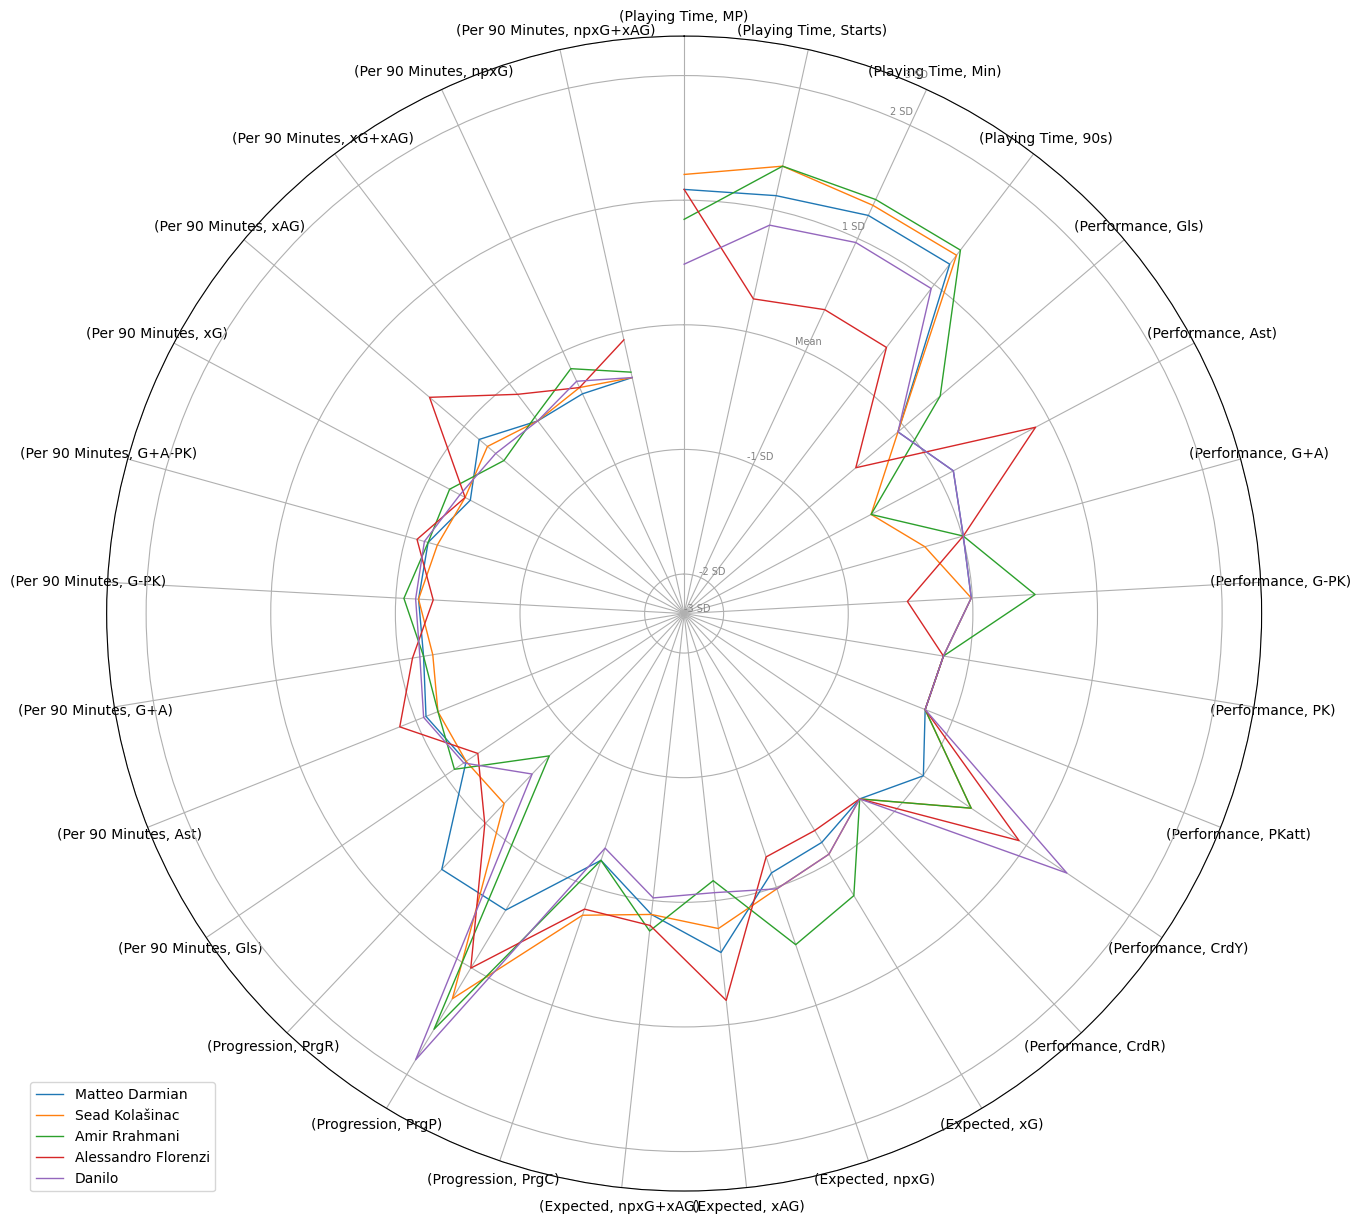

In [272]:
import numpy as np
import matplotlib.pyplot as plt

# Rimuovi la colonna "(Background Information, Position)" dalle colonne rilevanti
relevant_cols.remove("(Background Information, Position)")
relevant_cols.remove("(Background Information, Year of Birth)")

# Funzione per creare un radar plot
def radar_plot(player_names, player_data, reference_data, attribute_labels, reference_player_name):
    labels = np.array(attribute_labels)
    num_vars = len(labels)

    # Compute angle for each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    ax.set_xticks(angles)
    ax.set_xticklabels(attribute_labels)

    # Draw ylabels
    ax.set_rscale('symlog')
    plt.yticks([-3, -2, -1, 0, 1, 2, 3], ["-3 SD", "-2 SD", "-1 SD", "Mean", "1 SD", "2 SD", "3 SD"], color="grey", size=7)
    plt.ylim(-3,3)

    # Plot data
    for i in range(len(player_names)):
        stats = player_data[i]
        if player_names[i] == reference_player_name:
            reference_stats = reference_data
            ax.plot(angles, reference_stats, linewidth=2, linestyle='solid', label=player_names[i])
        else:
            ax.plot(angles, stats, linewidth=1, linestyle='solid', label=player_names[i])

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    return plt.show()

# Esempio di utilizzo:
player_names = [df.loc[player_index]['(Background Information, Full Name)'] for player_index, _ in top_similar_players]
player_data = [normalized_df.loc[player_index][relevant_cols] for player_index, _ in top_similar_players]
reference_data = normalized_df.loc[reference_player_index][relevant_cols]
attribute_labels = relevant_cols

radar_plot(player_names, player_data, reference_data, attribute_labels, reference_player_name)


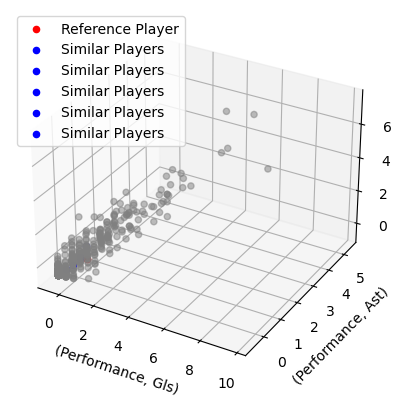

In [231]:

# Seleziona gli attributi per la visualizzazione tridimensionale
plot_attributes = ['(Performance, Gls)', '(Performance, Ast)', '(Expected, xG)']

# Prepara i dati per il plotting
player_data = normalized_df.loc[:, plot_attributes].values
reference_player_data = reference_player[plot_attributes].values

# Plot tridimensionale
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot di tutti i giocatori in grigio
ax.scatter(player_data[:,0], player_data[:,1], player_data[:,2], c='grey', alpha=0.5)

# Plot del giocatore di riferimento in rosso
ax.scatter(reference_player_data[0], reference_player_data[1], reference_player_data[2], c='red', label='Reference Player')

# Plot dei giocatori simili in blu
for player_index, _ in top_similar_players:
    player_data = normalized_df.loc[player_index, plot_attributes].values
    ax.scatter(player_data[0], player_data[1], player_data[2], c='blue', label='Similar Players')

ax.set_xlabel(plot_attributes[0])
ax.set_ylabel(plot_attributes[1])
ax.set_zlabel(plot_attributes[2])

plt.legend()
plt.show()



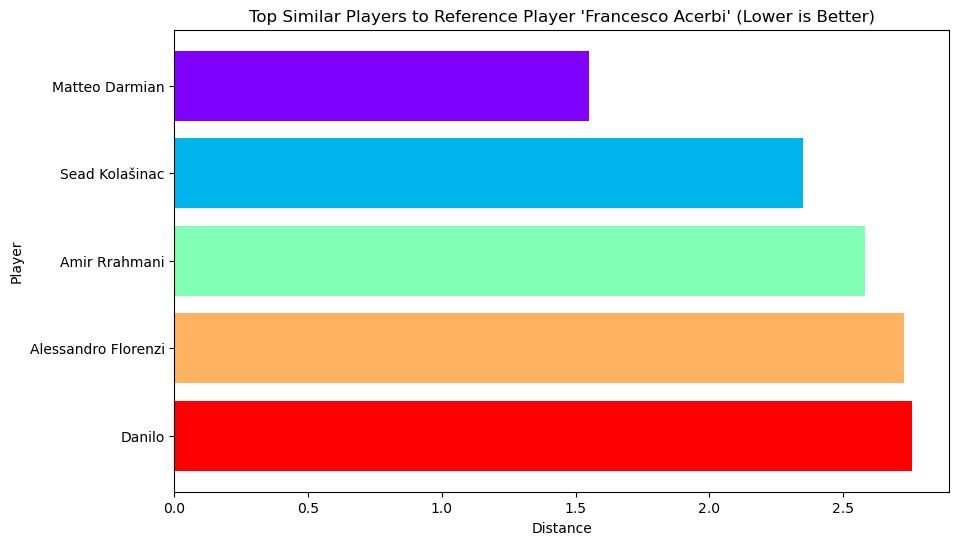

In [218]:
import matplotlib.pyplot as plt
import numpy as np

# Estrai i nomi e le distanze dei giocatori più simili
similar_player_names = [df.loc[player_index]['(Background Information, Full Name)'] for player_index, _ in top_similar_players]
similar_player_distances = [distance for _, distance in top_similar_players]

# Definisci i colori in ordine dell'arcobaleno
colors = plt.cm.rainbow(np.linspace(0, 1, len(similar_player_names)))

# Traccia il grafico a barre
plt.figure(figsize=(10, 6))
bars = plt.barh(similar_player_names, similar_player_distances, color=colors)

plt.xlabel('Distance')
plt.ylabel('Player')
plt.title(f'Top Similar Players to Reference Player \'{reference_player_name}\' (Lower is Better)')
plt.gca().invert_yaxis()  # Inverti l'asse y per avere il giocatore più simile in cima
plt.show()


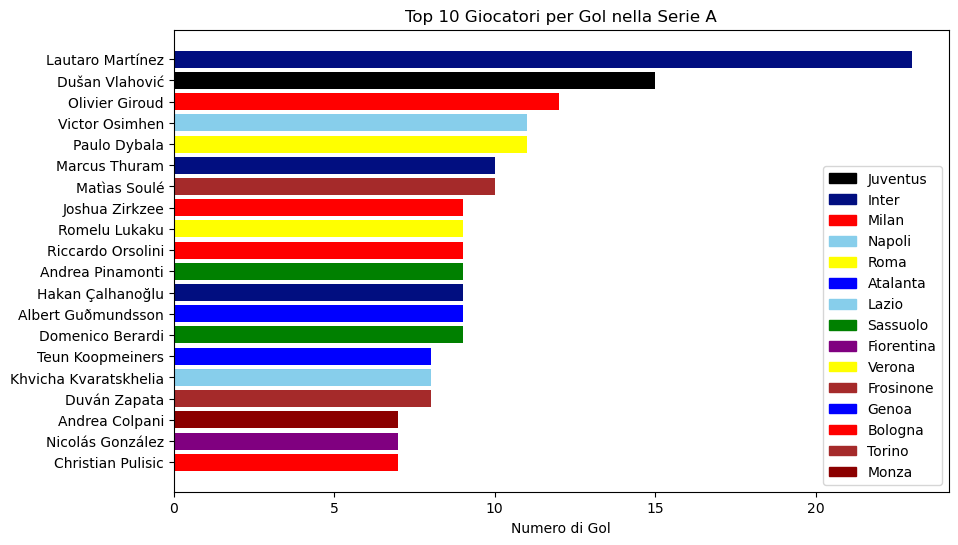

In [219]:
import matplotlib.pyplot as plt

# Definisci una mappatura di colori per ciascuna squadra
colors = {'Juventus': '#000000',    # Nero
          'Inter': '#010E80',       # Blu
          'Milan': '#FF0000',       # Rosso
          'Napoli': '#87CEEB',      # Celeste
          'Roma': '#FFFF00',        # Giallo
          'Atalanta': '#0000FF',    # Blu
          'Lazio': '#87CEEB',       # Celeste
          'Sassuolo': '#008000',    # Verde
          'Fiorentina': '#800080',  # Viola
          'Verona': '#FFFF00',      # Giallo
          'Frosinone': '#A52A2A',   # Marrone
          'Genoa': '#0000FF',       # Blu
          'Bologna': '#FF0000',     # Rosso
          'Torino': '#A52A2A',      # Marrone
          'Monza': '#8B0000'}       # Rosso scuro


# Ordina il DataFrame per il numero di gol
df_sorted = df.sort_values(by='(Performance, Gls)', ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
bars = plt.barh(df_sorted['(Background Information, Full Name)'], df_sorted['(Performance, Gls)'], 
                color=[colors[squad] for squad in df_sorted['(Background Information, Squad)']])
plt.xlabel('Numero di Gol')
plt.title('Top 10 Giocatori per Gol nella Serie A')
plt.gca().invert_yaxis()

# Aggiungi legenda per le squadre
legend_colors = [plt.Rectangle((0,0),1,1, color=color) for color in colors.values()]
plt.legend(legend_colors, colors.keys())

plt.show()

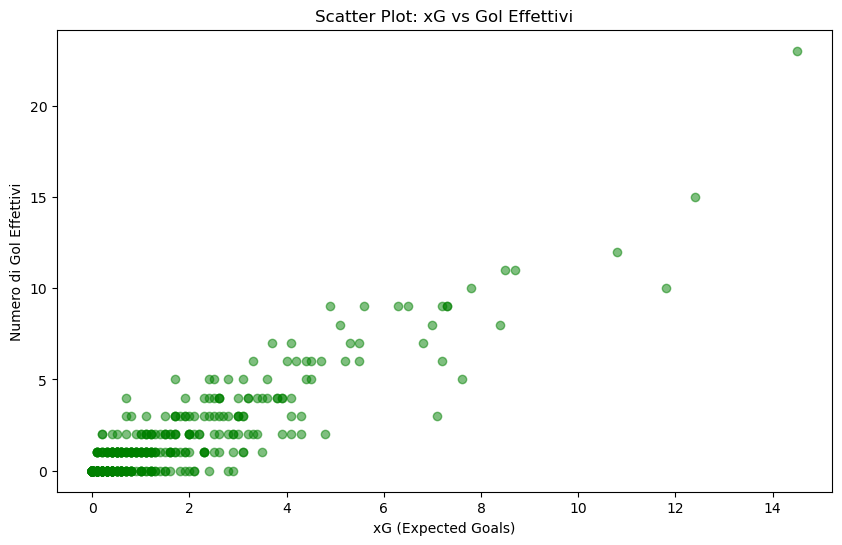

In [230]:
plt.figure(figsize=(10,6))
plt.scatter(df['(Expected, xG)'], df['(Performance, Gls)'], color='green', alpha=0.5)
plt.xlabel('xG (Expected Goals)')
plt.ylabel('Numero di Gol Effettivi')
plt.title('Scatter Plot: xG vs Gol Effettivi')
plt.show()


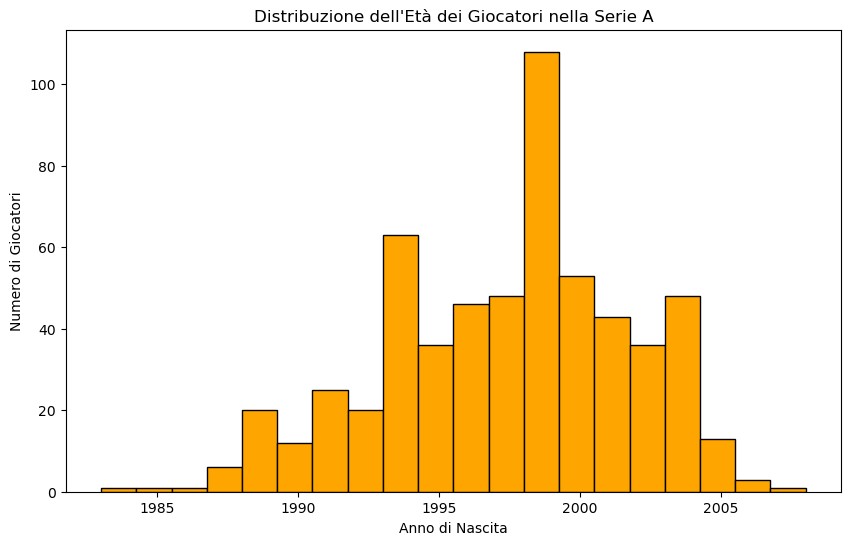

In [231]:
plt.figure(figsize=(10,6))
plt.hist(df['(Background Information, Year of Birth)'], bins=20, color='orange', edgecolor='black')
plt.xlabel('Anno di Nascita')
plt.ylabel('Numero di Giocatori')
plt.title('Distribuzione dell\'Età dei Giocatori nella Serie A')
plt.show()
